In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

align fingerprints


In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

In [ ]:
import chemfp

self = library_designer

class Generator:
    
    def __init__(self, molecule):
        self.molecule = molecule
        self.fingerprints = library_designer.fingerprints
        self.building_blocks = library_designer.building_blocks
        self.indices = None
        self.scores = None
    
    @staticmethod
    def boltzmann(scores, temperature):
        from scipy.special import softmax
        temperature += 1e-2
        probabilities = softmax(np.log(scores) / temperature)
        return probabilities

    def transform_and_choose(self, indices, scores, temperature, size):

        # # Convert probabilities
        probabilities = self.boltzmann(scores, temperature)

        # Sample choice
        choice = np.random.choice(indices, p=probabilities, size=size, replace=False)

        return choice

    def score_analogs(self, molecule):
        
        # Perform similarity search
        result = chemfp.simsearch(
            k = 2_000,
            query = molecule.smiles,
            targets = self.fingerprints
        )

        # Collect scores
        indices, scores = zip(*result.get_indices_and_scores())
        
        return indices, scores
        
    def generate(self, temperature=0.1, size=1):

        if not self.indices:
            self.indices, self.scores = self.score_analogs(self.molecule)
        
        # Choose analog
        choices = self.transform_and_choose(self.indices, self.scores, temperature, size)
        analogs = [self.building_blocks[choice.item()] for choice in choices]

        return analogs
    
    def __repr__(self):
        return f'Generator({self.molecule.smiles})'

In [30]:
%%time
from rdkit import Chem
from dgym.molecule import Molecule
from itertools import permutations

def unique_sanitize(mol):
    
    # Sanitize
    smiles = Chem.MolToSmiles(mol[0])
    product = Chem.MolFromSmiles(smiles)
    
    # Check unique
    if product and smiles not in library_designer.cache:
        library_designer.cache.add(smiles)
        return smiles

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 31.5 µs


Debug finding analogs.

In [31]:
import chemfp

def get_analog_indices_and_scores(molecules):
    
    fingerprint_type = library_designer.fingerprints.get_fingerprint_type()
    
    fingerprints = [
        (m.id, fingerprint_type.from_smi(m.smiles))
        for m in molecules
    ]
    
    queries = chemfp.load_fingerprints(
        fingerprints,
        metadata = fingerprint_type.get_metadata(),
        reorder=False
    )
    
    return chemfp.simsearch(
        queries = queries,
        targets = library_designer.fingerprints,
        progress=False,
        k=500
    )

In [32]:
import torch

def boltzmann(scores, temperature):
    """
    Applies the Boltzmann distribution to the given scores with a specified temperature.

    Parameters
    ----------
    scores : torch.Tensor
        The scores to which the Boltzmann distribution is applied.
    temperature : float
        The temperature parameter of the Boltzmann distribution.

    Returns
    -------
    torch.Tensor
        The probabilities resulting from the Boltzmann distribution.
    """
    temperature = max(temperature, 1e-2)  # Ensure temperature is not too low
    scaled_scores = scores / temperature
    probabilities = torch.softmax(scaled_scores, dim=-1)
    return probabilities

In [33]:
def generate_combos(lst, r, k=500):
    
    if r < 1:
        yield [], lst

    all_combinations = list(combinations(lst, r))
    selected_combinations = choices(all_combinations, k=k)
    for combo in selected_combinations:
        nonselected_items = tuple(item for item in lst if item not in combo)
        yield combo, nonselected_items

In [216]:
from random import choices
from itertools import combinations

original_reactants = deck[414].reactants
original_mols = [o.mol for o in original_reactants]

# Score analogs of each original reactant
analogs = get_analog_indices_and_scores(original_reactants)
indices = np.array(list(analogs.iter_indices()))
scores = list(analogs.iter_scores())

# Convert scores to probabilities
probabilities = boltzmann(torch.tensor(scores), 0.0)

# Sample indices
samples_idx = torch.multinomial(probabilities, 500)
samples = torch.gather(torch.tensor(indices), 1, samples_idx).T

def generate_reactants():
    
    count = 0
    while True:
        
        # Gather constant and variable masks
        combos = generate_combos([0, 1], 1)
        constant_mask, variable_mask = next(combos)
        
        # Get variable reactants
        variable = samples[count, variable_mask].tolist()
        variable_reactants = [library_designer.building_blocks[v] for v in variable]
        
        # Get constant reactants
        constant_reactants = [original_mols[c] for c in constant_mask]
        
        # Yield reactants
        reactants = [*constant_reactants, *variable_reactants]
        yield reactants
        
        # Increment
        count += 1

In [217]:
def enumerate_products():

    products = []
    
    # Only run products with reactions of right size
    reactions = [
        reaction
        for reaction in library_designer.reactions
        if len(reaction.reactants) == len(original_reactants)
    ]
    
    if reactions:
        
        # Loop through permutations of reactants
        for reactants in generate_reactants():
            for reactant_order in permutations(reactants):
                for reaction in reactions:

                    # Check if completed enumeration
                    if len(products) >= num_products:
                        return products

                    # Verify reactants match
                    if len(reactants) == len(reaction.reactants):

                        # Perform reaction
                        if output := reaction.run(reactant_order):
                            for product in output:
                                
                                # Check if valid molecule
                                if smiles := unique_sanitize(product):
                                    products += [Molecule(smiles, reactants = reactant_order)]
                        else:
                            continue

In [218]:
%%time
library_designer.reset_cache()
num_products = 10

products = enumerate_products()

CPU times: user 20.3 ms, sys: 76 µs, total: 20.4 ms
Wall time: 21.8 ms


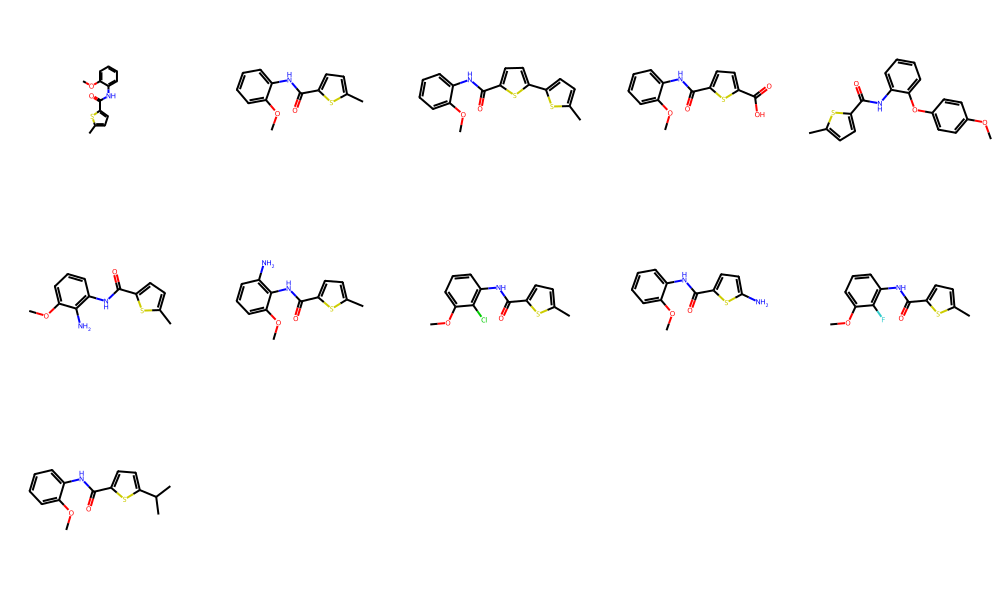

In [219]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([deck[414].mol, *[p.mol for p in products]], molsPerRow=5)

In [220]:
np.mean([_similarity(deck[414], p) for p in products])

0.7671780861415007

In [194]:
np.mean([_similarity(deck[414], p) for p in products])

0.6011764319219199

In [184]:
from rdkit.Chem import AllChem, DataStructs

def _similarity(mol1, mol2):
    """
    Calculate the Tanimoto similarity between two molecules represented by their SMILES strings.

    Parameters
    ----------
    smiles1 : str
        The SMILES representation of the first molecule.
    smiles2 : str
        The SMILES representation of the second molecule.

    Returns
    -------
    float
        The Tanimoto similarity between the two molecules.
    """    
    # Generate Morgan fingerprints
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1.mol, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2.mol, 2)

    # Calculate Tanimoto similarity
    similarity = DataStructs.FingerprintSimilarity(fp1, fp2)

    return similarity
